In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

# to generate the full matrix of input data from a list of possibilities
import itertools 

# to sanity check some pymc3 results against normal logistic regression results
from sklearn.linear_model import LogisticRegression 

# to enable saving traces that take a long time to generate
import pickle

In [4]:
pd.set_option('display.max_rows', 500)

**TODO** Add in all sections before code

# Load and prep Pew poll data

In [8]:
# TODO move to local dir and check in when it looks good
d = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/Oct16/pew_poll.csv')
d.shape

(2583, 6)

In [9]:
d[:2]

,state,sex,q10horseGP,race3m1,race3m2,weight
0,Minnesota,Male,Trump/lean Trump,"White (e.g., Caucasian, European, Irish, Itali...",NaN,2.088235
1,Delaware,Female,Clinton/lean Clinton,"White (e.g., Caucasian, European, Irish, Itali...",NaN,1.264706


In [10]:
#from collections import defaultdict
racethn_to_index = {
    "White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)": 1,
    "Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)": 2,
    "Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)": 3,
    "Some other race (SPECIFY____ IF NEEDED: What race or races is that?)": 4,
    "Native American/American Indian/Alaska Native (VOL.)": 5,
    "Pacific Islander/Native Hawaiian (VOL.)": 6,
    "Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)": 7,
    "Don't know (VOL.)": 8,
    "Refused (e.g., non-race answers like American, Human, purple) (VOL.)": 9
}

d['race3m1_index'] = d['race3m1'].map(racethn_to_index)
d['race3m2_index'] = d['race3m2'].map(racethn_to_index)

In [11]:
def get_racecmb(row):
    if ((row['race3m2_index'] > 0) & (row['race3m2_index'] < 8)):
        return 'Mixed Race'
    elif (row['race3m1_index'] == 1):
        return 'White'
    elif (row['race3m1_index'] == 2):
        return 'Black or African-American'
    elif (row['race3m1_index'] == 3):
        return 'Asian or Asian-American'
    elif (row['race3m1_index'] >= 4 & row['race3m1_index'] <= 7):
        return 'Or some other race'
    elif ((row['race3m1_index'] >= 8) & (row['race3m1_index'] <= 9)):
        return 'Dont know/Refused (VOL.)'

In [12]:
d['racecmb'] = d.apply(get_racecmb, axis=1)

In [13]:
d['racecmb'].value_counts(dropna=False)

White                        1935
Black or African-American     258
Or some other race            230
Asian or Asian-American        83
Mixed Race                     77
Name: racecmb, dtype: int64

**TODO** sanity check above numbers... are they right?

In [16]:
d['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton     972
Trump/lean Trump         858
Not registered           466
Johnson/lean Johnson     124
DK-refused to lean        76
Stein/lean Stein          57
Other-refused to lean     30
Name: q10horseGP, dtype: int64

In [17]:
d_only = d[(d['q10horseGP'] == 'Clinton/lean Clinton') | 
           (d['q10horseGP'] == 'Trump/lean Trump')]
d_only.shape

(1830, 9)

In [18]:
d_only['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton    972
Trump/lean Trump        858
Name: q10horseGP, dtype: int64

**TODO** note revisit of states now that we've filtered.

In [24]:
len(d_only['state'].unique())

50

Talk about how we should have 51...

In [25]:
d_only['state'].value_counts(dropna=False)

California              158
Texas                   133
Florida                 123
New York                121
Pennsylvania             75
Ohio                     72
New Jersey               68
Georgia                  62
Michigan                 61
North Carolina           61
Virginia                 60
Illinois                 57
Minnesota                48
Arizona                  45
Washington               45
Wisconsin                43
Tennessee                37
Kentucky                 34
Missouri                 34
Colorado                 33
Indiana                  33
South Carolina           33
Maryland                 30
Oregon                   29
Louisiana                28
Massachusetts            28
Oklahoma                 26
Alabama                  22
Iowa                     19
Kansas                   19
Nevada                   18
Idaho                    18
Connecticut              17
West Virginia            15
Utah                     15
Mississippi         

In [26]:
d_only[d_only['state'] == 'South Dakota']

,state,sex,q10horseGP,race3m1,race3m2,weight,race3m1_index,race3m2_index,racecmb


We don't have any rows in our two-party data w/ South Dakota, so absent any extra work on our part, we won't have a dummy indicator variable for SD, which'll make it harder to do stuff w/ the state later. We'll add it here when we're forming the dummies w/ states.

In [28]:
# add South Dakota, using the same index to make sure we don't extra cols (prob a better way to do this)
state_dummies = pd.concat([pd.get_dummies(d_only['state']), 
                           pd.Series(name='South Dakota', data=np.repeat(0, len(d_only)), index=d_only.index)], axis=1)
# alphabetize to put SD in the right spot
state_dummies = state_dummies.reindex(sorted(state_dummies.columns), axis=1)
state_dummies.shape

(1830, 51)

In [29]:
state_count = len(state_dummies.columns.values)
state_count

51

In [45]:
state_number_to_name = dict(list(zip(range(0,51), sorted(state_dummies.columns.values))))
state_number_to_name

{0: 'Alabama',
 1: 'Alaska',
 2: 'Arizona',
 3: 'Arkansas',
 4: 'California',
 5: 'Colorado',
 6: 'Connecticut',
 7: 'Delaware',
 8: 'District of Columbia',
 9: 'Florida',
 10: 'Georgia',
 11: 'Hawaii',
 12: 'Idaho',
 13: 'Illinois',
 14: 'Indiana',
 15: 'Iowa',
 16: 'Kansas',
 17: 'Kentucky',
 18: 'Louisiana',
 19: 'Maine',
 20: 'Maryland',
 21: 'Massachusetts',
 22: 'Michigan',
 23: 'Minnesota',
 24: 'Mississippi',
 25: 'Missouri',
 26: 'Montana',
 27: 'Nebraska',
 28: 'Nevada',
 29: 'New Hampshire',
 30: 'New Jersey',
 31: 'New Mexico',
 32: 'New York',
 33: 'North Carolina',
 34: 'North Dakota',
 35: 'Ohio',
 36: 'Oklahoma',
 37: 'Oregon',
 38: 'Pennsylvania',
 39: 'Rhode Island',
 40: 'South Carolina',
 41: 'South Dakota',
 42: 'Tennessee',
 43: 'Texas',
 44: 'Utah',
 45: 'Vermont',
 46: 'Virginia',
 47: 'Washington',
 48: 'West Virginia',
 49: 'Wisconsin',
 50: 'Wyoming'}

In [30]:
d_only_dummies = pd.concat([pd.get_dummies(d_only['sex'], drop_first=True),
                            pd.get_dummies(d_only['racecmb']),
                            state_dummies], axis=1)
d_only_dummies.shape

(1830, 57)

In [31]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate full set of cell input data

In [154]:
all_cells_list = list(itertools.product(np.sort(d_only['sex'].unique()), 
                                        np.sort(d_only['racecmb'].unique()),
                                        sorted(state_number_to_name.values())))
all_cells_list[:2]

[('Female', 'Asian or Asian-American', 'Alabama'),
 ('Female', 'Asian or Asian-American', 'Alaska')]

In [155]:
len(all_cells_list)

510

In [254]:
all_cells = pd.DataFrame(all_cells_list, columns=['sex','racecmb','state'])
all_cells[:2]

,sex,racecmb,state
0,Female,Asian or Asian-American,Alabama
1,Female,Asian or Asian-American,Alaska


In [255]:
# remove sex_Female since we only need one col for sex
all_cells_dummies = pd.get_dummies(all_cells).drop('sex_Female', 1)
all_cells_dummies[:3]

,sex_Male,racecmb_Asian or Asian-American,racecmb_Black or African-American,racecmb_Mixed Race,racecmb_Or some other race,racecmb_White,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Model

In [19]:
y_obs_categorical = pd.Categorical(d_only['q10horseGP'])
y_obs = y_obs_categorical.codes

sum(y_obs == 0), sum(y_obs == 1)

(972, 858)

In [20]:
y_obs_categorical

[Trump/lean Trump, Clinton/lean Clinton, Trump/lean Trump, Trump/lean Trump, Clinton/lean Clinton, ..., Trump/lean Trump, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton]
Length: 1830
Categories (2, object): [Clinton/lean Clinton, Trump/lean Trump]

Clinton is 0, Trump is 1.

**TODO** Note when writing docs that I have a lot of simpler and other models in the research notebook, and that I'm only showing the final one here.

In [34]:
vals_sex = d_only_dummies.values[:,0]
vals_racecmb = d_only_dummies.values[:,1:6]
vals_state = d_only_dummies.values[:,6:]

vals_sex.shape, vals_racecmb.shape, vals_state.shape

((1830,), (1830, 5), (1830, 51))

In [159]:
def standard_logistic(x):
    return 1 / (1 + np.exp(-x))

In [57]:
with pm.Model() as model_complete:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(d_only['racecmb'].unique()))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=1, 
                          shape=state_count)

    mu = alpha + \
         vals_sex * beta_sex + \
         pm.math.dot(vals_racecmb, beta_race) + \
         pm.math.dot(vals_state, beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # try calculating probability as part of the chain
    #all_cells_values_matrix = np.c_[np.ones(len(all_cells_dummies)), all_cells_dummies]
    all_cells_values_matrix = all_cells_dummies.values
    probs = pm.Deterministic('probs', standard_logistic(alpha + \
                 all_cells_values_matrix[:,0] * beta_sex + \
                 pm.math.dot(all_cells_values_matrix[:,1:6], beta_race) + \
                 pm.math.dot(all_cells_values_matrix[:,6:], beta_state)))
#     log_probs = pm.Deterministic('log_probs', alpha + \
#                  all_cells_values_matrix[:,0] * beta_sex + \
#                  pm.math.dot(all_cells_values_matrix[:,1:6], beta_race) + \
#                  pm.math.dot(all_cells_values_matrix[:,6:], beta_state))

    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [58]:
with model_complete:
    trace_complete = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1999/2000 [07:00<00:00,  4.04it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 2000/2000 [07:00<00:00,  4.75it/s]


In [59]:
varnames_model_complete = ['alpha', 'beta_sex', 
                           'mu_race', 'sigma_race', 'beta_race',
                           'mu_state', 'beta_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d34f550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1279354e0>]], dtype=object)

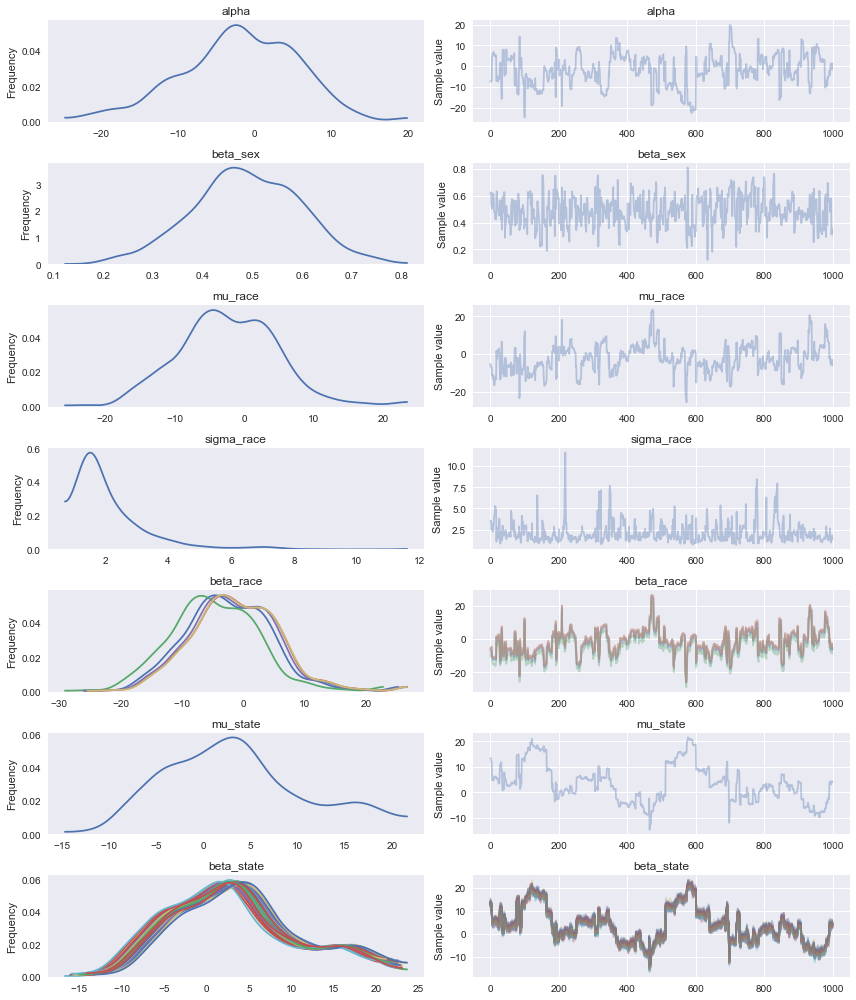

In [60]:
pm.traceplot(trace_complete, varnames_model_complete)

In [ ]:
plt.figure(figsize=(6,11))
pm.forestplot(trace_complete, varnames_model_complete)

In [ ]:
plt.figure(figsize=(6,80))
pm.forestplot(trace_complete, ['probs'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14da9fac8>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x14fba7da0>]], dtype=object)

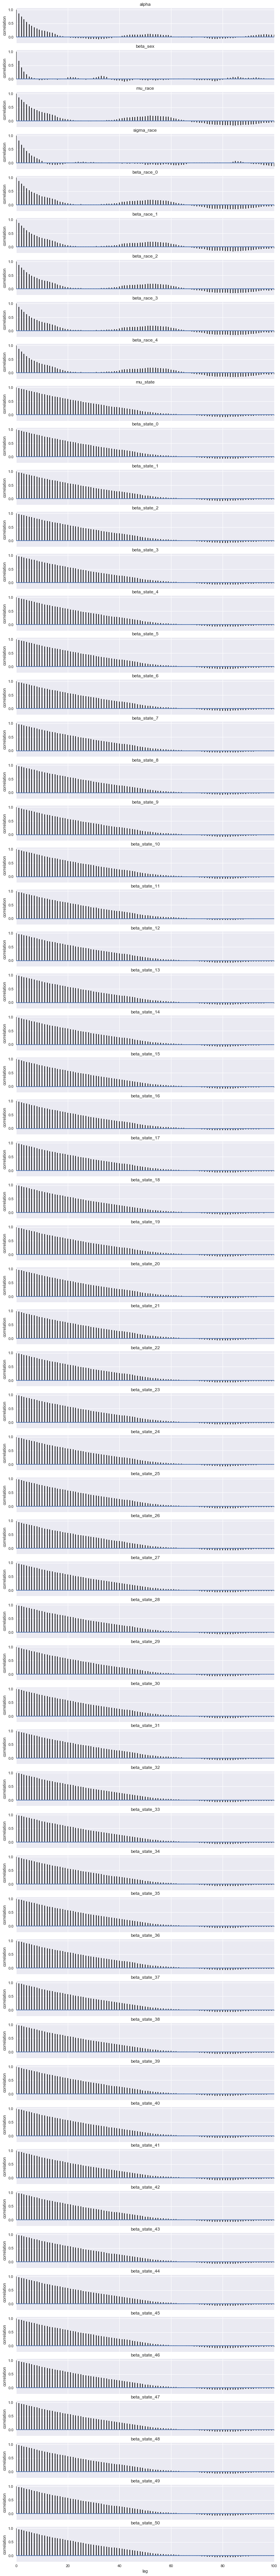

In [153]:
pm.autocorrplot(trace_complete, varnames_model_complete)

In [160]:
pm.df_summary(trace_complete, varnames_model_complete)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.747572,8.055614,0.656853,-15.808886,15.518778
beta_sex,0.488187,0.109142,0.006653,0.256697,0.676144
mu_race,-0.181419,8.529590,0.708934,-16.153687,16.626516
sigma_race,2.311291,1.504376,0.114010,0.654079,5.794350
beta_race__0,-0.452455,8.561393,0.715011,-16.590978,15.937976
beta_race__1,-2.655694,8.536295,0.712496,-19.110017,13.571170
beta_race__2,0.978904,8.558128,0.715399,-15.298932,17.237648
beta_race__3,0.544786,8.560568,0.716036,-15.339910,17.332676
beta_race__4,0.913585,8.553379,0.715092,-15.138328,17.425748
mu_state,-0.175705,6.240021,0.600374,-12.333133,11.807607


# Predictions

predictions

In [256]:
def classify_with_matrix(values_matrix, threshold, trace_data, varnames, add_intercept=False):
    if add_intercept:
        # add a column at the beginning with all ones, to match up w/ something like an alpha param
        values_matrix = np.c_[np.ones(len(values_matrix)), values_matrix]

    mean_vals = pm.df_summary(trace_data, varnames)['mean'].values

    mu = np.dot(values_matrix, mean_vals)

    prob = standard_logistic(mu)
    return prob, prob > threshold

In [257]:
probs, _ = classify_with_matrix(all_cells_dummies, 0.5, trace_complete,
                                ['alpha','beta_sex','beta_race','beta_state'], add_intercept=True)
probs.shape

(510,)

In [258]:
all_cells['trump_prob'] = probs
all_cells.shape

(510, 4)

In [259]:
all_cells[:2]

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.367146
1,Female,Asian or Asian-American,Alaska,0.318009


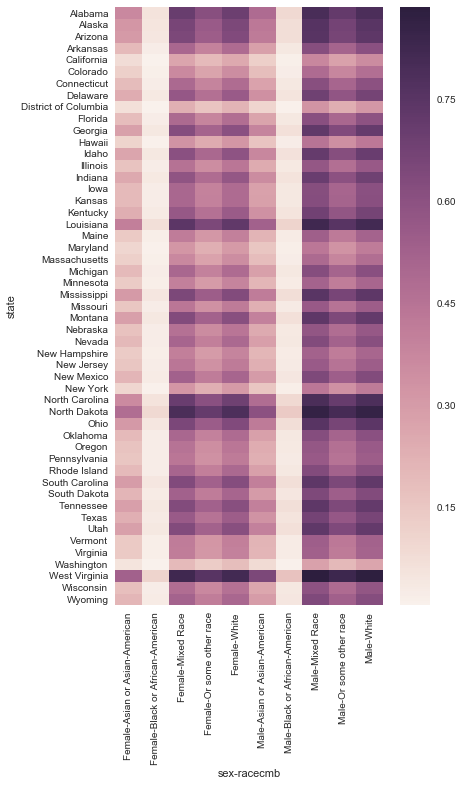

In [260]:
plt.figure(figsize=(6,11))
sns.heatmap(all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob'))

Side note: changing the SD on the beta_state params does appear to have kept the indiv state coefs, for those states w/ small amts of data, from blowing out and overwhelming the impact of the sex and race coefs. I don't know if it's caused too much impact on the other states - hopefully not, because they have enough data that they can still end up where they should be? I want to check w/ the actual changes below in the post-stratified predictions.

### Add in probability data from the chain itself, for comparison and possibly to show uncertainty

In [261]:
all_cells_with_trace = pd.concat([all_cells, pm.df_summary(trace_complete, ['probs']).reset_index(drop=True)], axis=1)
all_cells_with_trace[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145


# CPS data

In [262]:
d_pop = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/cps_population.csv')
d_pop.shape

(185487, 4)

In [263]:
d_pop[:2]

,RACE,WTSUPP,SEX,STATECENSUS
0,White,1132.05,Female,Maine
1,White,1077.54,Female,Maine


## Mapping CPS values to Pew values

Based on the quick examination of the fields I'm using right now, I think sex and state are actually good to go w/ no further work. For race I'll need to map, as CPS has a lot more values.

In [264]:
map_cps_race_to_pew_racecmb = {
    'White':'White',
    'Black/Negro':'Black or African-American',
    'Asian only':'Asian or Asian-American',
    'American Indian/Aleut/Eskimo':'Or some other race',
    'White-American Indian':'Mixed Race',
    'White-Black':'Mixed Race',
    'Hawaiian/Pacific Islander only':'Or some other race',
    'White-Asian':'Mixed Race',
    'White-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian':'Mixed Race',
    'Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-Black-American Indian':'Mixed Race',
    'White-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-Asian':'Mixed Race',
    'White-Black-Asian':'Mixed Race',
    'Four or five races, unspecified':'Mixed Race',
    'Black-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian':'Mixed Race',
    'Two or three races, unspecified':'Mixed Race',
    'American Indian-Asian':'Mixed Race',
    'White-Black-American Indian-Asian':'Mixed Race',
    'White-Black--Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian-Asian':'Mixed Race'
}
map_cps_race_to_pew_racecmb

d_pop['mapped_racecmb'] = d_pop['RACE'].map(map_cps_race_to_pew_racecmb)

d_pop['mapped_racecmb'].value_counts(dropna=False)

White                        142972
Black or African-American     22872
Asian or Asian-American       10709
Mixed Race                     4690
Or some other race             4244
Name: mapped_racecmb, dtype: int64

## Add predicted votes

In [265]:
population_by_cell = d_pop.groupby(['SEX','mapped_racecmb','STATECENSUS'], as_index=False)['WTSUPP'].sum()
population_by_cell.shape

(510, 4)

In [270]:
all_cells_with_pop = all_cells_with_trace.merge(population_by_cell, 
                                                left_on=['sex','racecmb','state'], 
                                                right_on=['SEX','mapped_racecmb','STATECENSUS'],
                                                validate='1:1')#[['sex','racecmb','state','trump_prob','WTSUPP']]
all_cells_with_pop.drop(columns=['SEX','mapped_racecmb','STATECENSUS'], inplace=True)
all_cells_with_pop.rename(columns={'WTSUPP':'population'}, inplace=True)
all_cells_with_pop[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07
2,Female,Asian or Asian-American,Arizona,0.307900,0.319776,0.115079,0.003314,0.100615,0.523859,124310.67


In [271]:
# confirm that the totals are the same in both our cell data and in the CPS data
round(all_cells_with_pop['population'].sum()), round(d_pop['WTSUPP'].sum())

(318868490.0, 318868490.0)

In [347]:
def add_vote_columns(df, population_col, prob_col, vote_col_prefix):
    """TODO doc, prob_col is prob of Trump vote"""
    df_new = df.copy()
    df_new[f"{vote_col_prefix}_clinton"] = np.round(df_new[population_col] * (1 - df_new[prob_col])).astype(int)
    df_new[f"{vote_col_prefix}_trump"] = np.round(df_new[population_col] * df_new[prob_col]).astype(int)

    return df_new

In [354]:
all_cells_with_results = add_vote_columns(all_cells_with_pop, 'population', 'trump_prob', 'votes')
all_cells_with_results[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19678,9176
2,Female,Asian or Asian-American,Arizona,0.307900,0.319776,0.115079,0.003314,0.100615,0.523859,124310.67,86035,38275


## And get prediction

In [273]:
def show_counts_and_proportions(clinton_count, trump_count):
    all_rows_count = clinton_count + trump_count
    print(f"Total  \t{all_rows_count:,}")
    print(f"Clinton\t{clinton_count:,} ({clinton_count / all_rows_count:.1%})")
    print(f"Trump  \t{trump_count:,} ({trump_count / all_rows_count:.1%})")
    print("")

In [274]:
show_counts_and_proportions(all_cells_with_results['votes_clinton'].sum(),
                            all_cells_with_results['votes_trump'].sum())

Total  	318,868,036
Clinton	180,741,829 (56.7%)
Trump  	138,126,207 (43.3%)



## What does the Pew poll say?

In [275]:
d_only['weight'].sum()

4904.5

In [276]:
d_only.groupby(['q10horseGP'])['weight'].sum()

q10horseGP
Clinton/lean Clinton    2628.352941
Trump/lean Trump        2276.147059
Name: weight, dtype: float64

In [277]:
show_counts_and_proportions(round(d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']['weight'].sum()),
                            round(d_only[d_only['q10horseGP'] == 'Trump/lean Trump']['weight'].sum()))

Total  	4,904.0
Clinton	2,628.0 (53.6%)
Trump  	2,276.0 (46.4%)



And if we don't use the weights, just for comparison?

In [278]:
show_counts_and_proportions(len(d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']),
                            len(d_only[d_only['q10horseGP'] == 'Trump/lean Trump']))

Total  	1,830
Clinton	972 (53.1%)
Trump  	858 (46.9%)



# Our predictions, adjusted by expected voting

In [279]:
d_voting = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/cps_votes.csv')
d_voting.shape

(131389, 5)

In [280]:
d_voting[:2]

,RACE,WTFINL,SEX,STATEFIP,VOTED
0,White,1878.9962,Male,Alabama,Voted
1,White,1519.4506,Female,Alabama,Did not vote


In [281]:
d_voting['mapped_racecmb'] = d_voting['RACE'].map(map_cps_race_to_pew_racecmb)
d_voting['mapped_racecmb'].value_counts(dropna=False)

White                        104857
Black or African-American     14055
Asian or Asian-American        6972
Mixed Race                     2901
Or some other race             2604
Name: mapped_racecmb, dtype: int64

In [282]:
d_voting_pop_by_cell = d_voting.groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_voting_pop_by_cell.shape

(508, 4)

Hmm... that should be 2 x 5 x 51 = 510. Which states don't have all one row for each cell?

In [283]:
(d_voting_pop_by_cell['STATEFIP'].unique())[d_voting_pop_by_cell.groupby('STATEFIP').size() < 10]

array(['Maine', 'Vermont'], dtype=object)

In [284]:
d_voting_pop_by_cell[d_voting_pop_by_cell['STATEFIP'] == 'Maine']

,SEX,mapped_racecmb,STATEFIP,WTFINL
19,Female,Asian or Asian-American,Maine,9754.6069
70,Female,Black or African-American,Maine,4462.1727
121,Female,Mixed Race,Maine,13686.0606
222,Female,White,Maine,644054.1601
273,Male,Asian or Asian-American,Maine,5334.7327
324,Male,Black or African-American,Maine,14303.7411
375,Male,Mixed Race,Maine,20999.6773
426,Male,Or some other race,Maine,5108.2904
476,Male,White,Maine,598546.5575


In [285]:
d_voting_pop_by_cell[d_voting_pop_by_cell['STATEFIP'] == 'Vermont']

,SEX,mapped_racecmb,STATEFIP,WTFINL
45,Female,Asian or Asian-American,Vermont,7194.2980
96,Female,Black or African-American,Vermont,3659.6508
147,Female,Mixed Race,Vermont,7383.7707
197,Female,Or some other race,Vermont,3078.2986
248,Female,White,Vermont,292484.9831
299,Male,Asian or Asian-American,Vermont,8141.2312
350,Male,Black or African-American,Vermont,4593.6401
401,Male,Mixed Race,Vermont,8969.2326
502,Male,White,Vermont,283089.8951


Turns out that Maine is missing females of 'Or some other race' and Vermont is missing males of 'Or some other race'.

In [286]:
d_voted_pop_by_cell = d_voting[d_voting['VOTED'] == 'Voted'].groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_voted_pop_by_cell.shape

(490, 4)

In [287]:
d_voted_pop_by_cell[:2]

,SEX,mapped_racecmb,STATEFIP,WTFINL
0,Female,Asian or Asian-American,Alabama,1822.7216
1,Female,Asian or Asian-American,Alaska,4588.3356


In [288]:
d_didnotvote_pop_by_cell = d_voting[d_voting['VOTED'] == 'Did not vote'].groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_didnotvote_pop_by_cell.shape

(475, 4)

In [289]:
d_didnotvote_pop_by_cell[:2]

,SEX,mapped_racecmb,STATEFIP,WTFINL
0,Female,Asian or Asian-American,Alabama,3167.1616
1,Female,Asian or Asian-American,Alaska,3133.0862


In [290]:
def get_voted_proportion(g):
    voted_count = g[g['VOTED'] == 'Voted']['WTFINL'].sum()
    if np.isnan(voted_count): # if there are no vote rows, then we had zero (don't think there's a way to do this via a built-in function)
        voted_count = 0
    
    didnotvote_count = g[g['VOTED'] == 'Did not vote']['WTFINL'].sum()
    if np.isnan(didnotvote_count): 
        didnotvote_count = 0

    total_count = voted_count + didnotvote_count
    
    if total_count != 0:
        return voted_count / (voted_count + didnotvote_count)
    else:
        return np.nan


# have to use reset_index instead of as_index=False because the latter isn't working w/ .apply
d_voted_prop = d_voting.groupby(['SEX','mapped_racecmb','STATEFIP']).apply(get_voted_proportion).reset_index()
d_voted_prop.rename(columns={0:'voted_prop','SEX':'sex','mapped_racecmb':'racecmb','STATEFIP':'state'}, inplace=True)
d_voted_prop[:5]

,sex,racecmb,state,voted_prop
0,Female,Asian or Asian-American,Alabama,0.365283
1,Female,Asian or Asian-American,Alaska,0.594235
2,Female,Asian or Asian-American,Arizona,0.721009
3,Female,Asian or Asian-American,Arkansas,1.000000
4,Female,Asian or Asian-American,California,0.617409


## Impute/guess at some proportions where we don't have data

In [291]:
all_cells_with_results[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175


In [292]:
all_cells_with_results_and_voted_prop = all_cells_with_results.merge(d_voted_prop, 
                on=['sex','racecmb','state'], how='left')
all_cells_with_results_and_voted_prop.shape

(510, 13)

In [293]:
all_cells_with_results_and_voted_prop[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235


The Nov 2016 monthly CPS data doesn't have voted data for every single one of the 510 cells. For two - noted (WHERE?) - there's no data at all/no rows at all for a particular combination, and for more there's at least some rows but there are no voted/did not vote rows for that cell. In either case, we have a nan, since we can't say anything at all about that cell. (There are also some cells where all of the rows are either vote or did not vote, and we've - for better or worse - already marked these as 100% or 0%, respectively.)

Also, I checked a few of the cells and the number of actual votes for the cells are small, so we likely won't change our results in ways we'd notice. 

For ease of implementation, we'll just set these values to the average voted proportion (overall - we could do it from common cells, but won't bother since the number of affected votes is so small).

In [294]:
voted_count = d_voting[d_voting['VOTED'] == 'Voted']['WTFINL'].sum()
did_not_vote_count = d_voting[d_voting['VOTED'] == 'Did not vote']['WTFINL'].sum()
overall_prop_voted = voted_count / (voted_count + did_not_vote_count)
overall_prop_voted

0.71859397336959685

In [295]:
all_cells_with_results_and_voted_prop['voted_prop'].fillna(overall_prop_voted, inplace=True)

In [296]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'].isnull()]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop


In [348]:
all_cells_with_results_and_adj_voted_data = all_cells_with_results_and_voted_prop.copy()
all_cells_with_results_and_adj_voted_data['est_population_voted'] = all_cells_with_results_and_adj_voted_data['population'] * \
                                                            all_cells_with_results_and_adj_voted_data['voted_prop']
all_cells_with_results_and_adj_voted_data = add_vote_columns(all_cells_with_results_and_adj_voted_data, 
                                                             'est_population_voted', 'trump_prob', 'votes_adj')

all_cells_with_results_and_adj_voted_data[:3]

# all_cells_with_results_and_adj_voted_data['votes_clinton_adj'] = np.round(all_cells_with_results_and_adj_voted_data['est_population_voted'] * \
#                                                             (1 - all_cells_with_results_and_adj_voted_data['trump_prob'])).astype(int)
# all_cells_with_results_and_adj_voted_data['votes_trump_adj'] = np.round(all_cells_with_results_and_adj_voted_data['est_population_voted'] * \
#                                                             all_cells_with_results_and_adj_voted_data['trump_prob']).astype(int)



,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283,18644.420075,11799,6845
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235,17145.491035,11693,5452
2,Female,Asian or Asian-American,Arizona,0.307900,0.319776,0.115079,0.003314,0.100615,0.523859,124310.67,86035,38275,0.721009,89629.100394,62032,27597


## What's the prediction based on counts adjusted for likelihood to vote?

In [298]:
show_counts_and_proportions(all_cells_with_results_and_adj_voted_data['votes_clinton_adj'].sum(),
                            all_cells_with_results_and_adj_voted_data['votes_trump_adj'].sum())

Total  	227,710,337
Clinton	129,211,403 (56.7%)
Trump  	98,498,934 (43.3%)



This proportion is dismayingly close to the original prediction - here 0.568 vs 0.567, even though the number of votes is so much smaller and, from an eyeball perspectie I thought that certain cells that I know have diff props for voting one or the other (for ex, depending on race) appeared to have a different likelihood to have voted. It's still different from the Pew prediction. If I did get this right, at least I tried it and showed that this alone isn't the cause of the difference.

TODO First off, I absolutely need to sanity check the above, especially the end (when I was most tired), and make sure everything holds up and is consistent. Perhaps I made obvious mistakes.

## Side check: how does the SD of the probability relate to the size of the cell?

I would expect that we have a lot more uncertainty, measured by the standard deviation of the probability, or by the width of the 95% credible interval, for cells with smaller numbers of people. Is this at least roughly the case?

Based at least on eyeballing the list below, which orders the cells in ascending size of the probability standard deviation, it looks like this is the case.

In [301]:
all_cells_with_results_and_adj_voted_data[['sex','racecmb','state','mean','sd','hpd_2.5','hpd_97.5','population']].sort_values(['sd'])

,sex,racecmb,state,mean,sd,hpd_2.5,hpd_97.5,population
98,Female,Black or African-American,Washington,0.007171,0.003830,0.001102,0.015154,133322.33
55,Female,Black or African-American,California,0.010506,0.004514,0.002743,0.019198,1275023.22
83,Female,Black or African-American,New York,0.013569,0.006122,0.003484,0.025581,1848125.35
353,Male,Black or African-American,Washington,0.011595,0.006139,0.002037,0.024468,152145.52
310,Male,Black or African-American,California,0.016960,0.007255,0.004494,0.031329,1211329.14
59,Female,Black or African-American,District of Columbia,0.010221,0.008130,0.000466,0.026529,175758.30
72,Female,Black or African-American,Massachusetts,0.017375,0.009268,0.003268,0.034693,298106.99
71,Female,Black or African-American,Maryland,0.014650,0.009317,0.002639,0.033116,976662.94
56,Female,Black or African-American,Colorado,0.017205,0.009522,0.002733,0.036130,113632.83
338,Male,Black or African-American,New York,0.021819,0.009661,0.006045,0.041328,1583874.80


## And what's the prediction if we use a simple logistic regression for the proportions?

In [325]:
d_only_dummies.shape

(1830, 57)

In [326]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [327]:
lr = LogisticRegression().fit(d_only_dummies.values, y_obs)

In [358]:
all_cells_with_results_and_adj_voted_data_and_lr_prob = all_cells_with_results_and_adj_voted_data.copy()
all_cells_with_results_and_adj_voted_data_and_lr_prob['lr_prob'] = \
    standard_logistic(all_cells_dummies.dot(lr.coef_.T) + lr.intercept_)
    
all_cells_with_results_and_adj_voted_data_and_lr_prob.shape

(510, 17)

In [360]:
all_cells_with_results_and_adj_voted_data_and_lr_prob[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283,18644.420075,11799,6845,0.392024
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235,17145.491035,11693,5452,0.331486


In [361]:
all_cells_with_results_and_adj_voted_data_and_lr = add_vote_columns(all_cells_with_results_and_adj_voted_data_and_lr_prob, 'population', 'lr_prob', 'lr_votes')
all_cells_with_results_and_adj_voted_data_and_lr[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob,lr_votes_clinton,lr_votes_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283,18644.420075,11799,6845,0.392024,31032,20009
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235,17145.491035,11693,5452,0.331486,19289,9564
2,Female,Asian or Asian-American,Arizona,0.307900,0.319776,0.115079,0.003314,0.100615,0.523859,124310.67,86035,38275,0.721009,89629.100394,62032,27597,0.335622,82589,41721


In [362]:
show_counts_and_proportions(all_cells_with_results_and_adj_voted_data_and_lr['lr_votes_clinton'].sum(),
                            all_cells_with_results_and_adj_voted_data_and_lr['lr_votes_trump'].sum())

Total  	318,868,502
Clinton	180,278,476 (56.5%)
Trump  	138,590,026 (43.5%)

